In [1]:
from ib_insync import *
import src.floor_ceiling_regime as fcr
import scripts.trend_viewer
util.startLoop()

ib = IB()
# port = 7496
port = 4001
ib.connect('127.0.0.1', port, clientId=0)

<IB connected to 127.0.0.1:4001 clientId=0>

In [2]:
%matplotlib inline

In [3]:
def run_static(symbol, sec_type, interval='1 min', duration='1 D', use_rth=True, find_retest_swing=True):
    contracts = ib.reqContractDetails(Contract(symbol=symbol, secType=sec_type, includeExpired=False))[0]
    contract = contracts.contract
    bars = ib.reqHistoricalData(
        contract,
        endDateTime='',
        durationStr=duration,
        barSizeSetting=interval,
        whatToShow='TRADES' if symbol not in ['BTC', 'ETH'] else 'AGGTRADES',
        useRTH=use_rth,
        formatDate=1,
        keepUpToDate=False
    )
    prices = util.df(bars).reset_index().rename(columns={'index': 'bar_number'})
    tables = fcr.fc_scale_strategy_live(prices, find_retest_swing=find_retest_swing)
    tables.enhanced_price_data = tables.enhanced_price_data[['close']].reset_index().rename(columns={'index': 'bar_number'})
    tables.enhanced_price_data = scripts.trend_viewer.setup_trend_view_graph_simple(
        tables.enhanced_price_data, 
        tables.regime_table, 
        tables.peak_table, 
        tables.floor_ceiling_table
    )
    return tables

def plot_static(symbol, sec_type, interval, duration, use_rth, find_retest_swing=False, window=252, plot_window=300, entries=False, bands=True):
    tables = run_static(
        symbol=symbol, 
        sec_type=sec_type,
        interval=interval,
        duration=duration,
        use_rth=use_rth,
        find_retest_swing=find_retest_swing
    )
    price = tables.enhanced_price_data.copy()
    if bands:
        price['rolling_max'] = price.close.rolling(window=window).max()
        price['rolling_min'] = price.close.rolling(window=window).min()
        price['trading_range'] = (price.rolling_max - price.rolling_min)
        price['trading_range_lo_band'] = price.rolling_min + price.trading_range * .61
        price['trading_range_hi_band'] = price.rolling_min + price.trading_range * .40
    scripts.trend_viewer.plot(price[-plot_window:], '', entries=entries)


In [4]:
_interval = '1 day'
_duration = '5 Y'

In [5]:
from src.regime import NotEnoughDataError

try: 
    mes_table = run_static('MES', 'FUT', _interval, _duration, False, find_retest_swing=False)
    mnq_table = run_static('MNQ', 'FUT', _interval, _duration, False, find_retest_swing=False)
    mes_price = mes_table.enhanced_price_data.rename(columns={'close': 'MES'})[['MES', 'bar_number']]
    mnq_price = mnq_table.enhanced_price_data.rename(columns={'close': 'MNQ'})[['MNQ', 'bar_number']]
    price = mes_price.merge(mnq_price, on='bar_number', how='outer')
    bm_mes = price.MNQ / price.MNQ[0]
    bm_mnq = price.MES / price.MES[0]
    price['rMES'] = price.MES / bm_mes
    price['rMNQ'] = price.MNQ / bm_mnq
    # plot mes with mnq as secondary y axis
    price[['MES', 'rMES']].plot(figsize=(20, 10))
except NotEnoughDataError:
    print('Not enough data')

Not enough data


In [6]:
try: 
    plot_static('MES', 'FUT', _interval, _duration, False, find_retest_swing=False, plot_window=3000)
except NotEnoughDataError:
    print('Not enough data')

Not enough data


/home/brian/repos/backtest_notebook/venv/lib/python3.10/site-packages/src/regime/utils.py:776: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[rg_ch] = df[rg_ch].ffill()
/home/brian/repos/backtest_notebook/scripts/trend_viewer.py:143: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _stock_data.rg_ch_val = _stock_data.rg_ch_val.ffill()


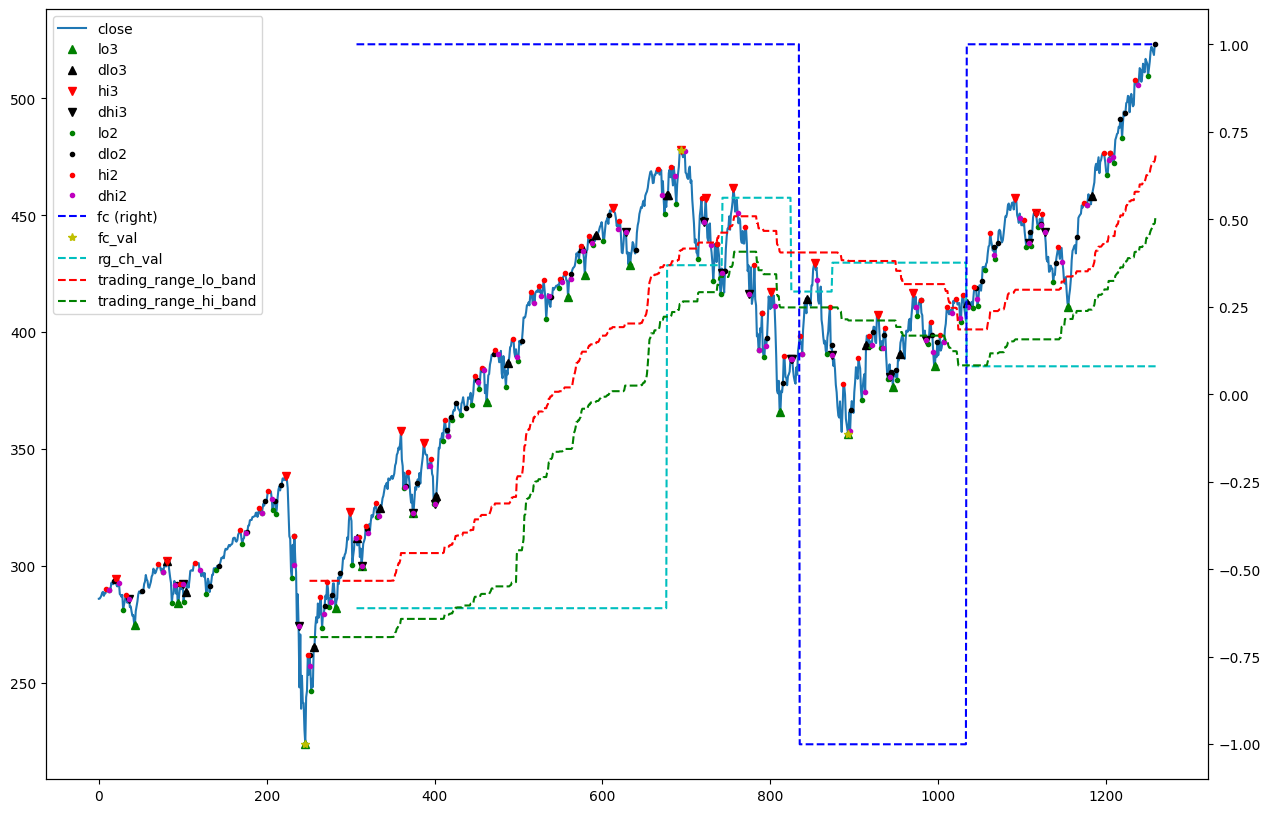

In [7]:
plot_static('SPY', 'STK', _interval, _duration, use_rth=True, find_retest_swing=False, plot_window=3000)

/home/brian/repos/backtest_notebook/venv/lib/python3.10/site-packages/src/regime/utils.py:776: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[rg_ch] = df[rg_ch].ffill()
/home/brian/repos/backtest_notebook/scripts/trend_viewer.py:143: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _stock_data.rg_ch_val = _stock_data.rg_ch_val.ffill()


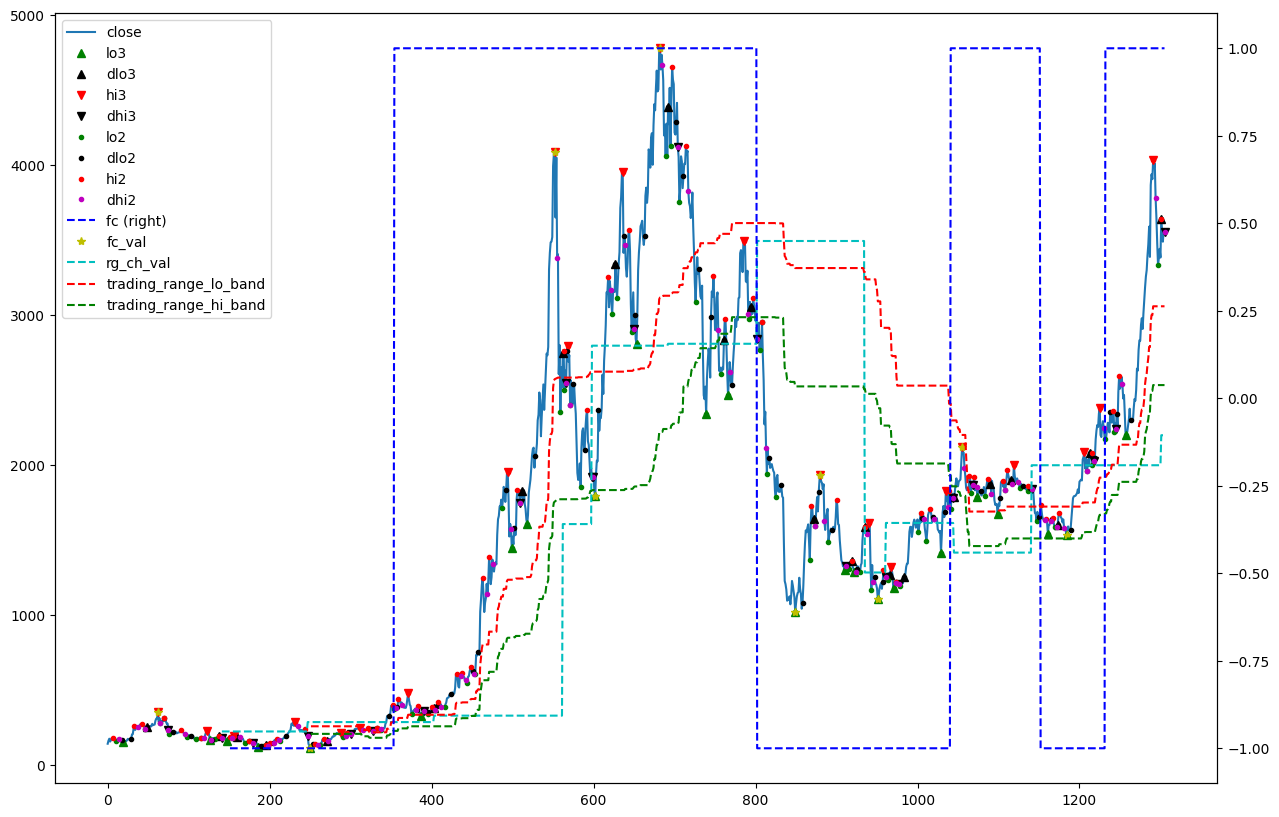

In [8]:
plot_static('ETH', 'CRYPTO', _interval, _duration, use_rth=True, find_retest_swing=False, plot_window=3000)

/home/brian/repos/backtest_notebook/venv/lib/python3.10/site-packages/src/regime/utils.py:776: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[rg_ch] = df[rg_ch].ffill()
/home/brian/repos/backtest_notebook/scripts/trend_viewer.py:143: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _stock_data.rg_ch_val = _stock_data.rg_ch_val.ffill()


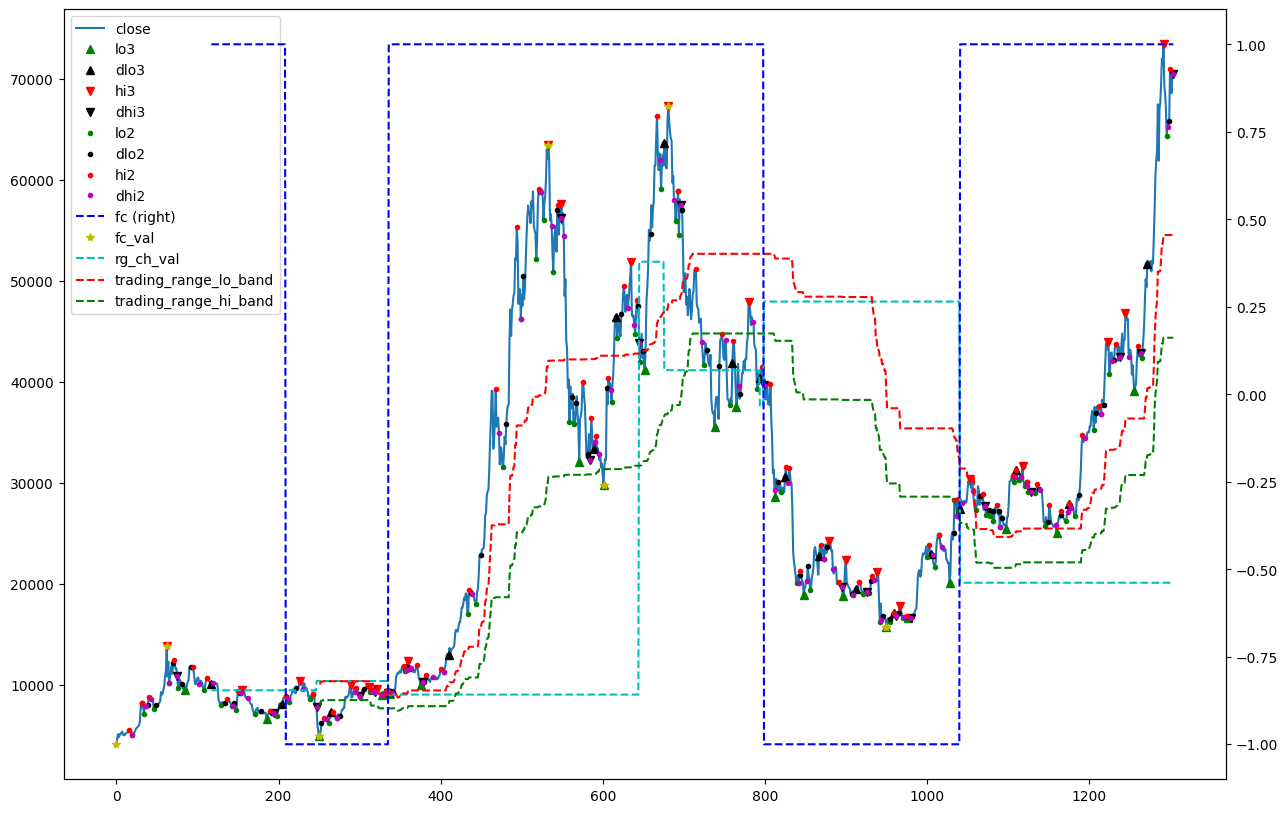

In [9]:
plot_static('BTC', 'CRYPTO', _interval, _duration, use_rth=True, find_retest_swing=False, plot_window=3000)

In [10]:
plot_static('GPS', 'STK', _interval, _duration, use_rth=True, find_retest_swing=False, plot_window=3000)

Error 162, reqId 14: Historical Market Data Service error message:No market data permissions for MEXI STK, contract: Contract(secType='STK', conId=38708396, symbol='GPS', exchange='MEXI', primaryExchange='MEXI', currency='MXN', localSymbol='GPS', tradingClass='GPS')


AttributeError: 'NoneType' object has no attribute 'reset_index'

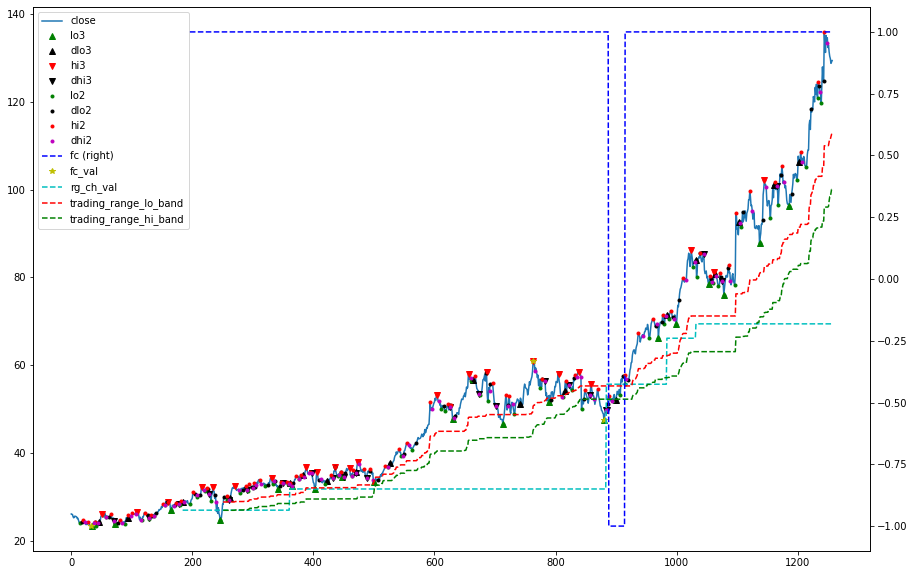

In [ ]:
plot_static('NVO', 'STK', _interval, _duration, use_rth=True, find_retest_swing=False, plot_window=3000)

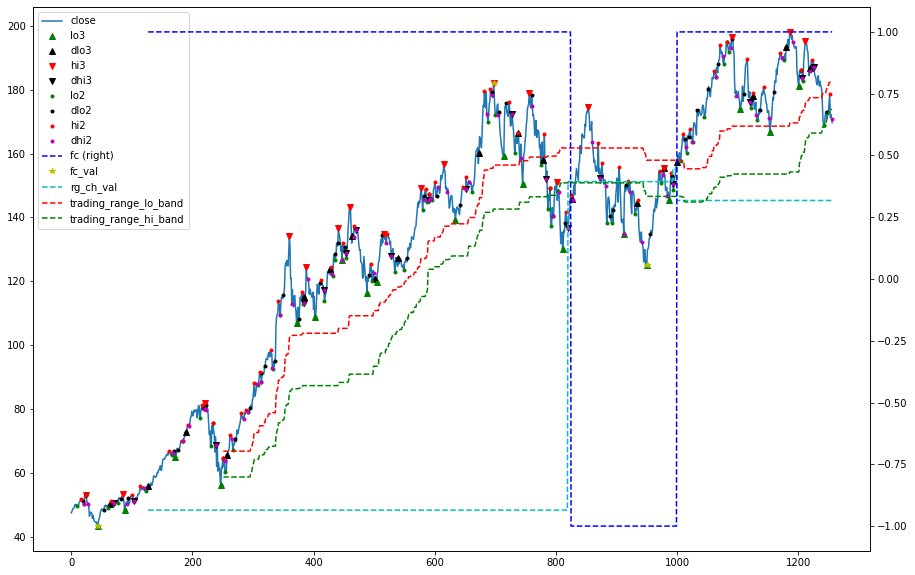

In [ ]:
plot_static('AAPL', 'STK', _interval, _duration, use_rth=True, find_retest_swing=False, plot_window=3000)

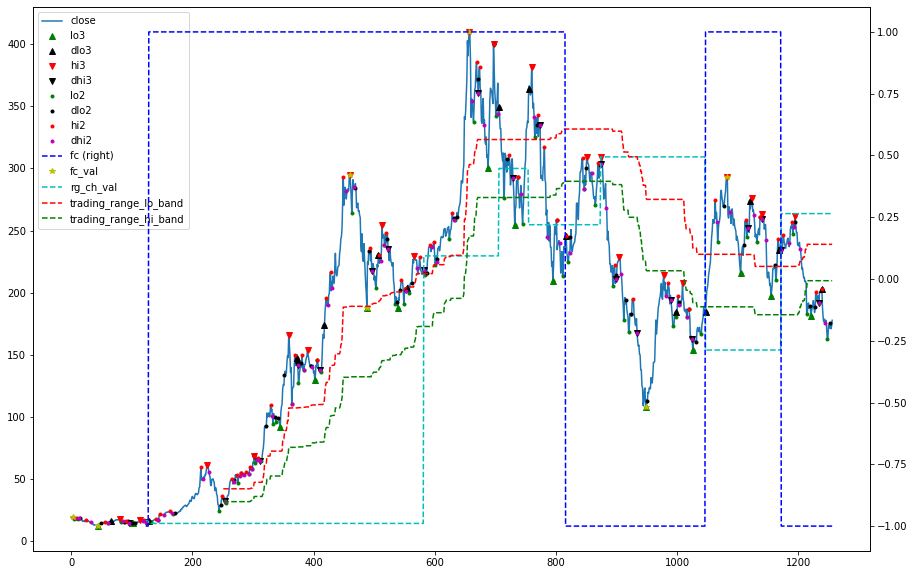

In [ ]:
plot_static('TSLA', 'STK', _interval, _duration, use_rth=True, find_retest_swing=False, plot_window=3000)

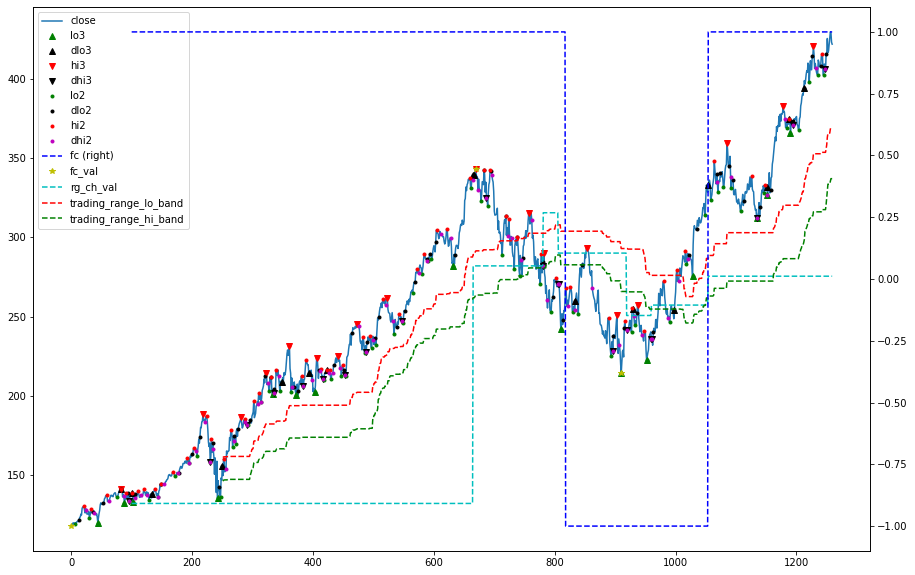

In [ ]:
plot_static('MSFT', 'STK', _interval, _duration, use_rth=True, find_retest_swing=False, plot_window=3000)

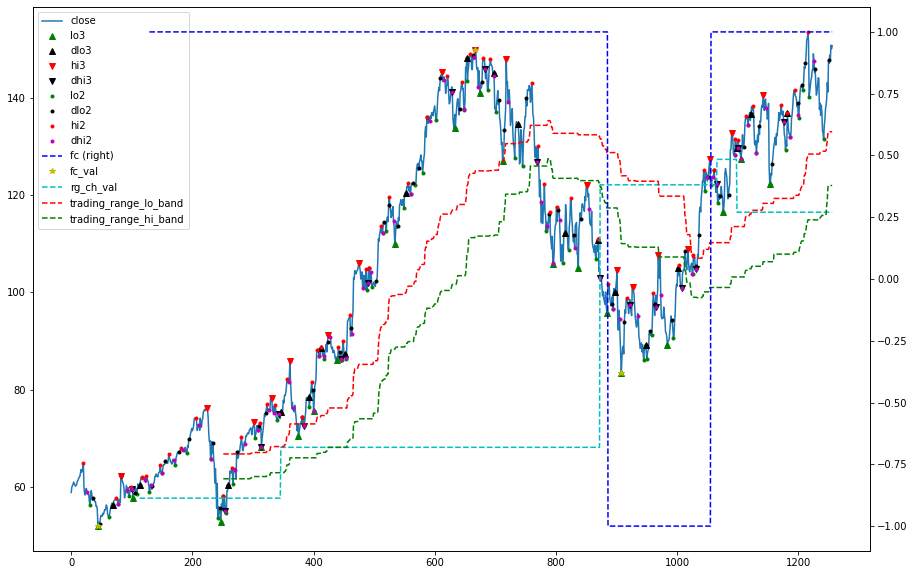

In [ ]:
plot_static('GOOGL', 'STK', _interval, _duration, use_rth=True, find_retest_swing=False, plot_window=3000)

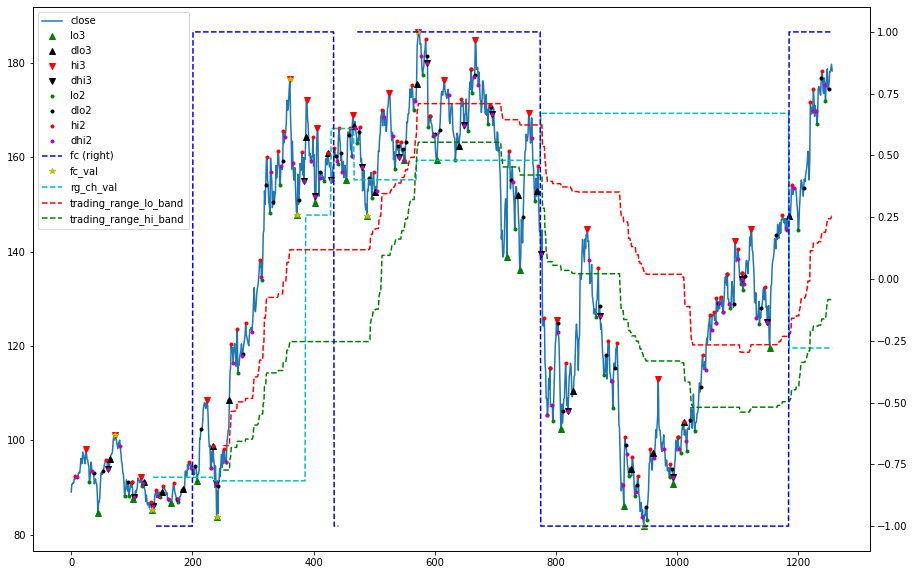

In [ ]:
plot_static('AMZN', 'STK', _interval, _duration, use_rth=True, find_retest_swing=False, plot_window=3000)

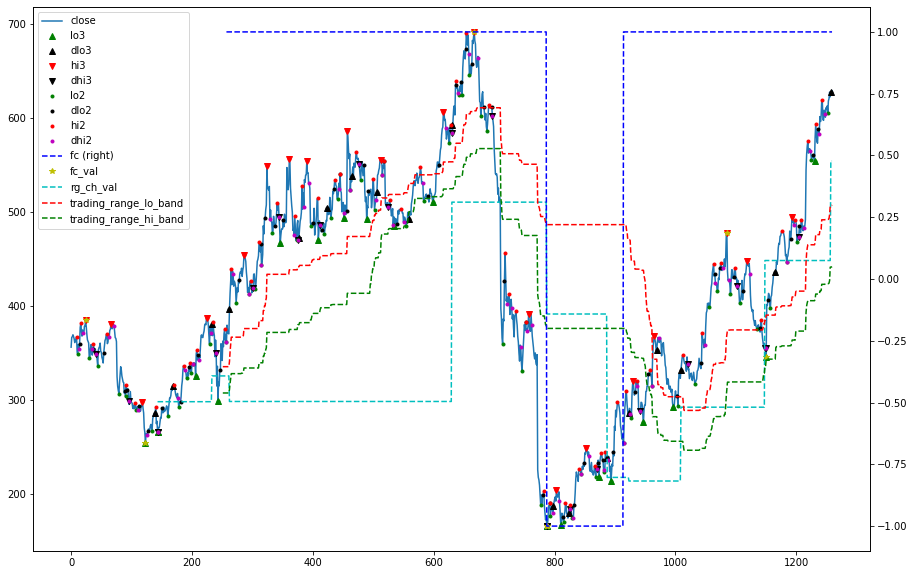

In [ ]:
plot_static('NFLX', 'STK', _interval, _duration, use_rth=True, find_retest_swing=False, plot_window=3000)

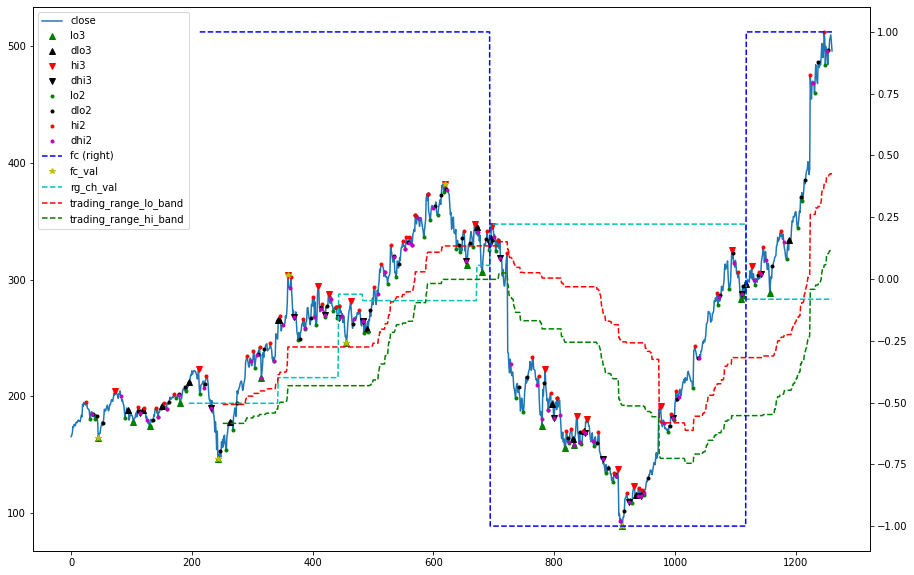

In [ ]:
plot_static('META', 'STK', _interval, _duration, use_rth=True, find_retest_swing=False, plot_window=3000)

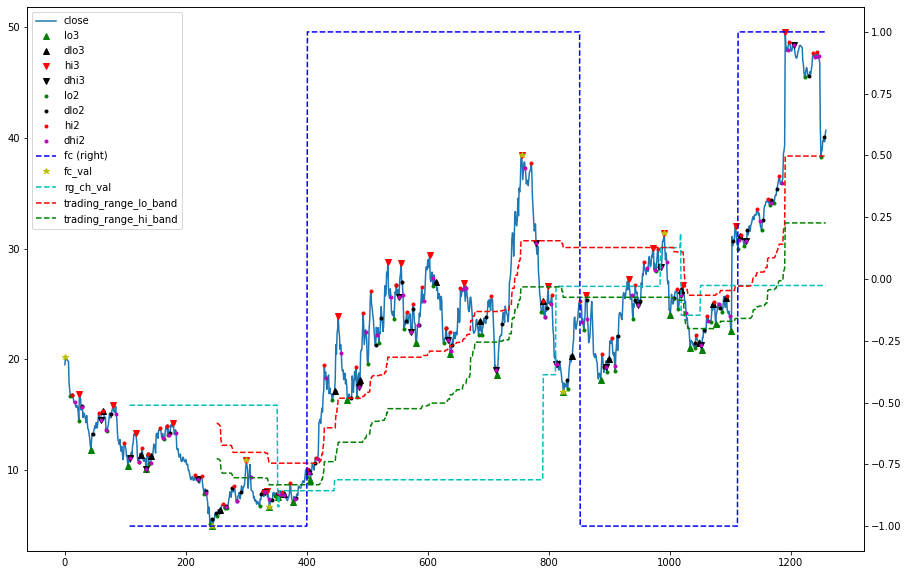

In [ ]:
plot_static('X', 'STK', _interval, _duration, use_rth=True, find_retest_swing=False, plot_window=3000)

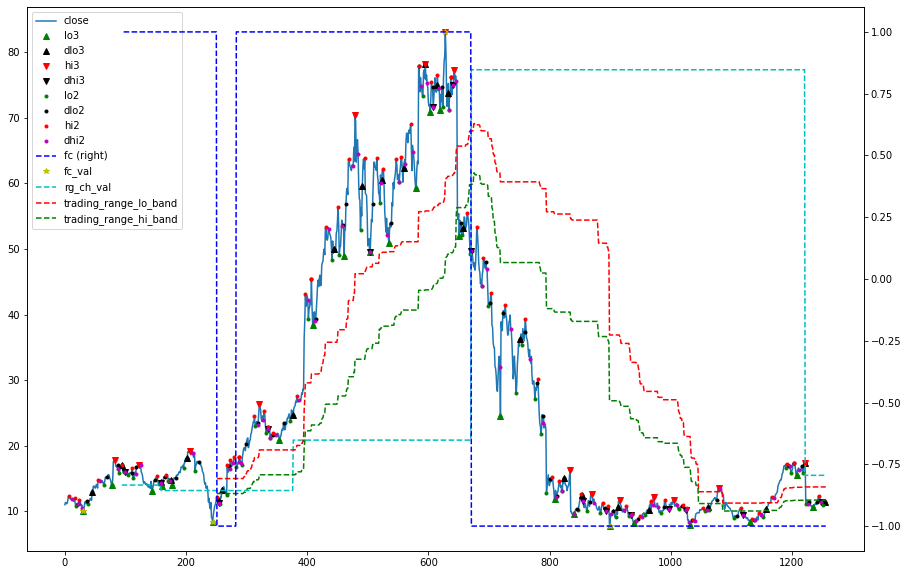

In [ ]:
plot_static('SNAP', 'STK', _interval, _duration, use_rth=True, find_retest_swing=False, plot_window=3000)

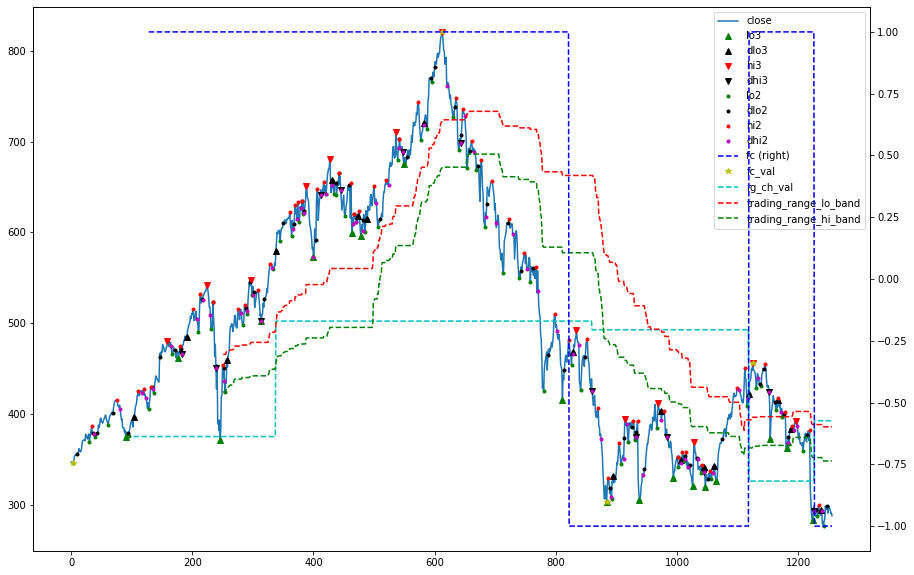

In [ ]:
plot_static('CHTR', 'STK', _interval, _duration, use_rth=True, find_retest_swing=False, plot_window=3000)

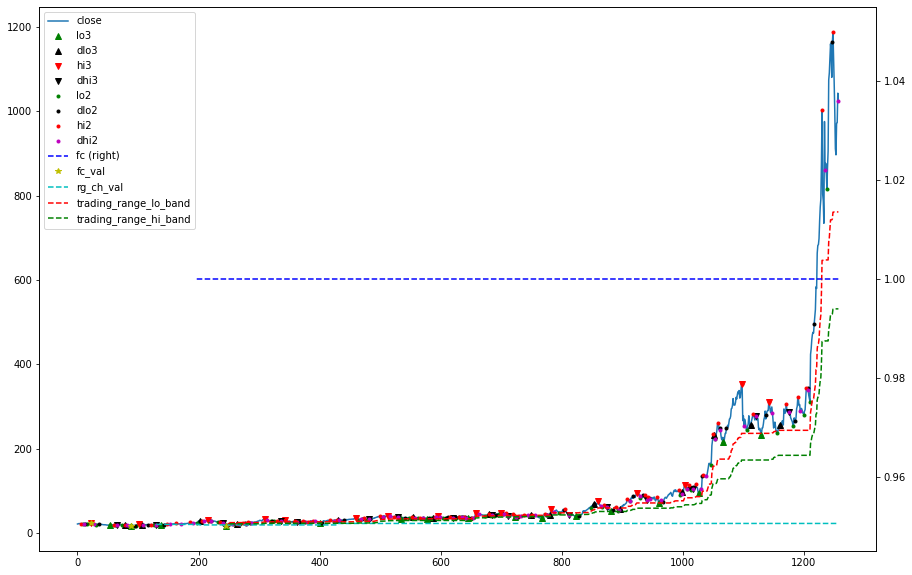

In [ ]:
plot_static('SMCI', 'STK', _interval, _duration, use_rth=True, find_retest_swing=False, plot_window=3000)

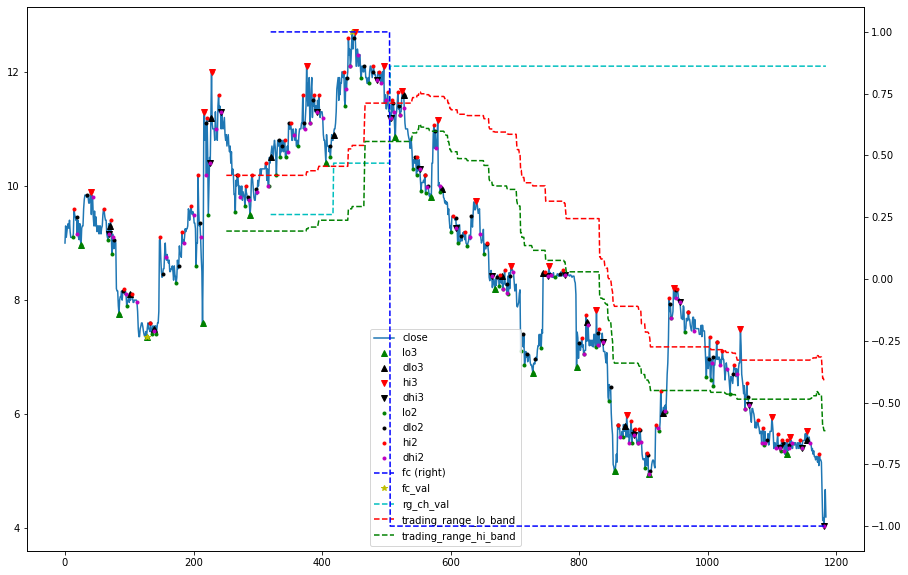

In [ ]:
plot_static('GME', 'STK', _interval, _duration, use_rth=True, find_retest_swing=False, plot_window=3000)

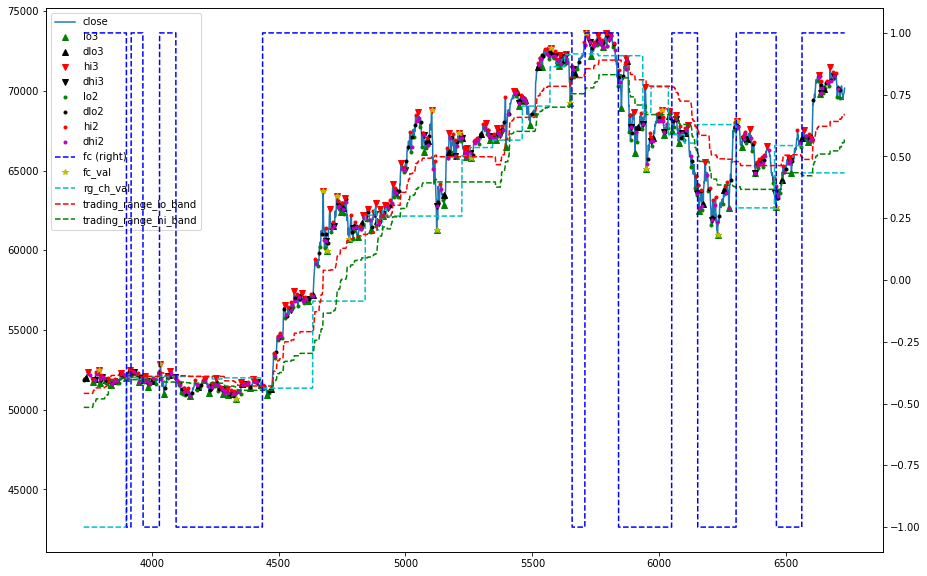

In [ ]:
plot_static('BTC', 'CRYPTO', '15 mins', "3 M", use_rth=True, find_retest_swing=False, plot_window=3000)

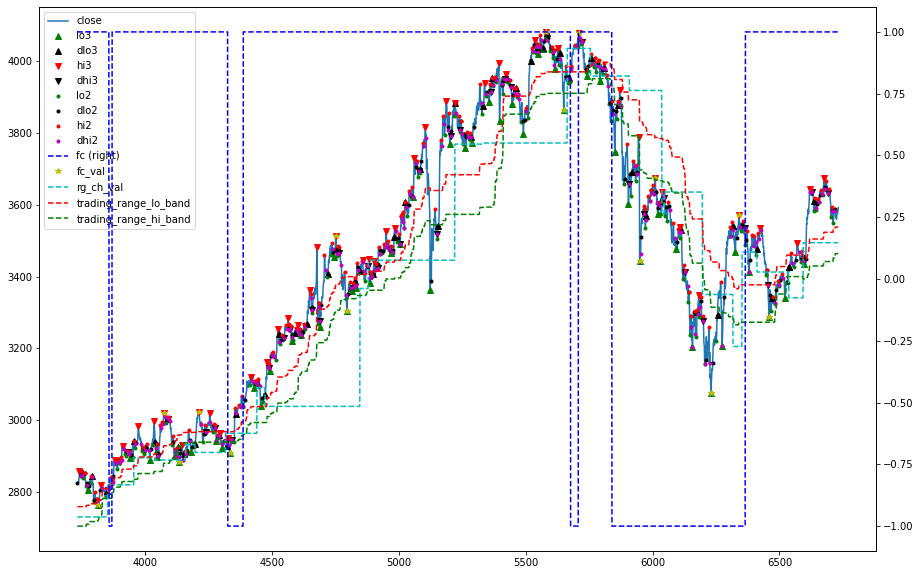

In [ ]:
plot_static('ETH', 'CRYPTO', '15 mins', "3 M", use_rth=True, find_retest_swing=False, plot_window=3000)

In [ ]:
import regime_classic

# for reference

start = '2023-1-1'
end = None
vlty_n = 63
dist_pct = 0.05
retrace_pct = 0.05
threshold = 1.5
dgt = 2
d_vol = 5
r_vol = 2.5
lvl = 3

def ib_get_historical(symbol, sec_type, duration, interval, use_rth=True): 
    contracts = ib.reqContractDetails(Contract(symbol=symbol, secType=sec_type, includeExpired=False))[0]
    contract = contracts.contract
    bars = ib.reqHistoricalData(
        contract,
        endDateTime='',
        durationStr=duration,
        barSizeSetting=interval,
        whatToShow='TRADES' if symbol not in ['BTC', 'ETH'] else 'AGGTRADES',
        useRTH=use_rth,
        formatDate=1,
        keepUpToDate=False
    )
    prices = util.df(bars)
    prices.index = prices.date 
    prices = prices.drop(columns=['date'])
    return prices

s = "ETH"
price_data = ib_get_historical(s, "CRYPTO", "5 Y", "1 day")
bench_data = ib_get_historical("SPY", "STK", "5 Y", "1 day")


price_data_with_swings = regime_classic.swings(price_data, bench_data, 'close', None, None, None, lvl, d_vol, dist_pct, vlty_n, r_vol, retrace_pct, dgt)
price_data_with_regime = regime_classic.regime(price_data_with_swings, 3, vlty_n, threshold)

regime_table = fcr.regime_ranges(price_data_with_regime, "rg")

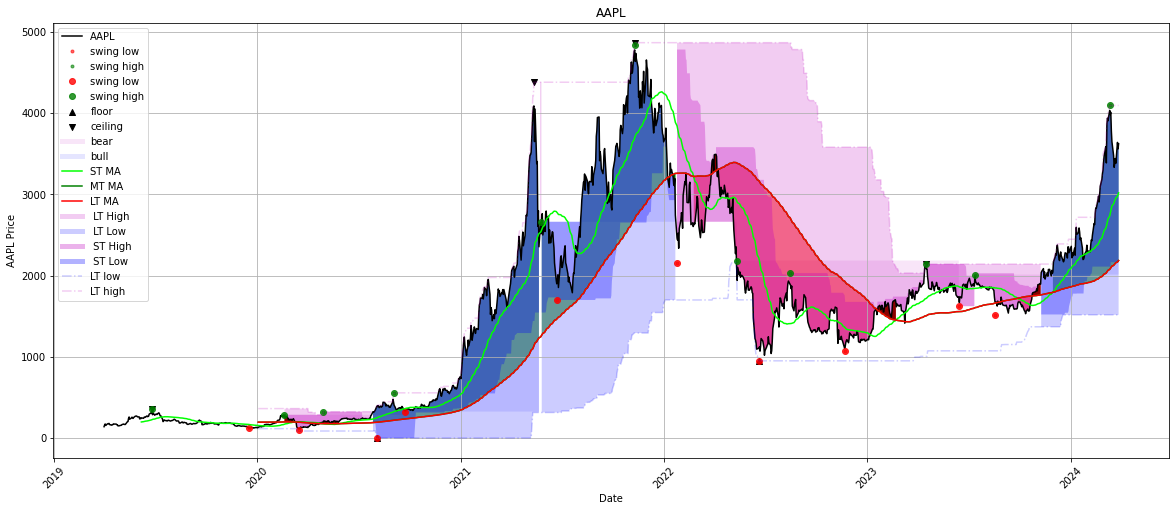

In [ ]:
st= fast = 50
lt = slow = 200
mav = [fast, slow, 200]
bo = [fast, slow]
_o,_h,_l,_c = regime_classic.lower_upper_OHLC(price_data_with_regime,relative = False)
ma_st,ma_mt,ma_lt = [price_data_with_regime[_c].rolling(mav[t]).mean() for t in range(len(mav))]
st_lo,lt_lo = [price_data_with_regime[_l].rolling(bo[t]).min() for t in range(len(bo))]
st_hi,lt_hi = [price_data_with_regime[_h].rolling(bo[t]).max() for t in range(len(bo))]
rg_combo = ['close','rg','lo'+str(lvl),'hi'+str(lvl),'lo'+str(lvl),'hi'+str(lvl),'clg','flr','rg_ch']
_c,rg,lo,hi,slo,shi,clg,flr,rg_ch =[rg_combo[r] for r in range(len(rg_combo)) ]
regime_classic.graph_regime_combo(s, price_data_with_regime, _c, rg, lo, hi, slo, shi, clg, flr, rg_ch, ma_st, ma_mt, ma_lt, lt_lo, lt_hi, st_lo, st_hi)